IMAGE CAPTIONING
Midjourney Images & Prompt: https://www.kaggle.com/datasets/cyanex1702/midjourney-imagesprompt
2/B Muhammed İhsan Karayeğit - G211210023
2/B Fatih Özdemir - G201210047
2/B Barış Cebeci - G201210045

PROJENİN AMACI 

Bu projenin amacı, Image Captioning (Görüntü Açıklama) modelini tanıtmak, bir örnek uygulama çalıştırmak ve bu uygulamayı farklı bir veri seti ile eğiterek performansını değerlendirmektir. Model, görüntülerden anlamlı açıklamalar üretmek için CNN ve Transformer yapılarını kullanır. 

Algoritma Tanıtımı:
    IMAGE CAPTIONING NEDİR? 
        Image captioning, bir görüntüyü analiz edip, bu görüntüye dair açıklayıcı bir metin oluşturma işlemidir. Bu işlem, doğal dil işleme (NLP) ve bilgisayarla görme (computer vision) alanlarını birleştirir. 

ALGORİTMANIN YAPISI VE TARİHÇESİ 
 
1. CNN (Convolutional Neural Network): 

    EfficientNet, 2019 yılında Google AI tarafından geliştirildi. Bu model, ölçeklenebilir bir CNN mimarisi sunar ve daha az parametreyle daha yüksek performans elde etmeyi hedefler 

    Özellik Çıkarma: CNN, görüntüyü bir dizi evrişimsel ve havuzlama katmanından geçirerek önemli özellikleri çıkarır. Bu katmanlar, görüntüdeki kenar, doku ve nesne gibi detayları öğrenir. 

    EfficientNet: Keras kütüphanesindeki önceden eğitilmiş EfficientNet modeli kullanılarak, görüntüden daha etkili özellikler çıkarılır. 

2. Transformer Encoder:  

    Transformer, 2017 yılında Vaswani ve arkadaşları tarafından tanıtılmıştır. Bu model, sinir ağlarının doğal dil işleme görevlerindeki performansını büyük ölçüde artırmıştır.Giriş: CNN'den elde edilen özellik haritası, Transformer encoder'a beslenir. 

    Pozisyonel Kodlama: Transformer, girdilere pozisyonel kodlama ekler, böylece model, dizideki kelimelerin konumunu öğrenebilir. 

    Katmanlar: Birkaç çoklu-bağlantı (multi-head attention) ve ileri besleme (feed-forward) katmanından oluşur. 

Çıktı: Encoder'ın son katmanından alınan çıktı, her pozisyondaki kelimenin anlamını temsil eder. 

3. Transformer Decoder: 

    Encoder'dan gelen temsilleri kullanarak, girişte verilen metin parçalarını analiz eder ve sonraki kelimeyi tahmin eder. 

    Giriş: Encoder'ın çıktısı ve daha önce üretilmiş kelimeler kullanılarak, yeni kelimeler tahmin edilir. 

    Maskeli Çoklu Bağlantı: Decoder, gelecekteki kelimeleri tahmin ederken, henüz tahmin edilmemiş kelimeleri maskeler. 

    Katmanlar: Benzer şekilde, birkaç çoklu-bağlantı ve ileri besleme katmanından oluşur. 

    Çıktı: Son katman, her pozisyondaki kelimenin olasılığını verir.

Örnek Veri Seti: 
    Burada veri seti olarak Flickr8k veri seti kullanılmış olup, her bir görüntüye karşılık gelen beş farklı metin açıklaması içerir. Bu veri seti içinde 8000 binde fazla resim ve toplamda 40.000 den fazla metin yazısı bulunmaktadır.
    

Aşağıda gerçekleştirmiş olduğumuz örnekte kaggle.com üzerinden bulmuş olduğumuz Flicker8k data seti ve bu data seti içerisindeki resimleri tanımlamak için metin belgeleri bulunmaktadır. Kodların hepsi başarılı bir şekilde çalıştırıldığında rastgele seçilmiş bir resmin açıklaması makine tarafından sağlanmaktadır.

İlk olarak proje için gerekli kütüphanelerin proje içine eklenmesi gerçekleştirildi.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

Gerekli değişkenler ve değerleri atanıp resimlerin bulunduğu dosya path olarak eklendi.

In [4]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

Aşağıda resim altyazı veri setini yükleyip işlemek için gerekli kodlar yazılmıştır.


1. load_captions_data Fonksiyonu:

    Bu fonksiyon, belirtilen dosya yolu (filename) üzerinden altyazı verilerini içeren bir dosyayı okur.
    Her altyazı, ilgili olduğu resmin adı ile birlikte bir satırda saklanır. Resim adı ve altyazı bir tab karakteriyle (\t) ayrılır.
    Altyazı verisi, resim adlarına göre bir sözlük (caption_mapping) içinde gruplandırılır ve ayrıca tüm altyazılar bir liste (text_data) içinde saklanır.
    Altyazıların başına ve sonuna özel başlangıç ve bitiş tokenları eklenir (<start> ve <end>).
    Çok kısa veya çok uzun altyazılar hariç tutulur ve bunlarla ilişkili resimler images_to_skip kümesine eklenir.

2. train_val_split Fonksiyonu:

    Bu fonksiyon, altyazıları içeren sözlüğü (caption_data) eğitim ve doğrulama setlerine ayırır.
    İsteğe bağlı olarak veri seti karıştırılabilir (shuffle=True).
    Belirlenen oranda (train_size=0.8) veri eğitim setine ayrılırken, geri kalanı doğrulama seti olarak kullanılır.

3. Veri Yükleme ve Setlere Ayırma:

    load_captions_data fonksiyonu kullanılarak "Flickr8k.token.txt" dosyasından altyazılar yüklenir.
    Daha sonra bu altyazılar train_val_split fonksiyonu ile eğitim ve doğrulama setlerine ayrılır.
    Her bir setteki örnek sayısı yazdırılır.

In [5]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


Modelinin eğitimi için metin ve resim verilerini işlemek amacıyla aşağıdaki kod yazılmıştır.

1. custom_standardization Fonksiyonu:

    Bu fonksiyon, metin verilerini standartlaştırmak için kullanılır. Amacı, gürültülü veya gereksiz karakterleri metinden çıkarmak ve metni küçük harflere dönüştürmektir.
    İlk olarak, gelen metni küçük harflere çevirir (tf.strings.lower).
    Daha sonra, belirli özel karakterleri metinden kaldırır. Bu karakterler strip_chars stringinde tanımlanmıştır ve < ve > karakterleri bu stringden çıkarılmıştır.

2. TextVectorization Nesnesi:

    TextVectorization, metin verilerini sayısal formata (tokenlara) dönüştürmek için kullanılır. Bu, metin tabanlı model eğitimi için önemli bir adımdır çünkü modeller ham metinle doğrudan çalışamaz.
    max_tokens (VOCAB_SIZE), kelime dağarcığının maksimum büyüklüğünü belirtir.
    output_mode="int" ayarı, metni tam sayılara dönüştürür, yani her kelimeyi bir sayısal token ile temsil eder.
    output_sequence_length=SEQ_LENGTH, her metin örneğinin uzunluğunu sabit bir değere sınırlar.
    standardize=custom_standardization, her metin örneği işlenmeden önce custom_standardization fonksiyonunu uygular.

3. vectorization.adapt(text_data) Çağrısı:

    Bu çağrı, TextVectorization nesnesini belirli bir metin veri setine göre uyarlar, yani bu metin verilerinden kelime dağarcığını oluşturur ve her kelimeye bir tam sayı atar.

4. image_augmentation için Keras Sequential Modeli:

    Bu model, resim verileri üzerinde artırma işlemleri gerçekleştirir. Artırma, modelin genelleme yeteneğini artırmak ve overfitting'i azaltmak için eğitim verilerini çeşitlendirir.
    layers.RandomFlip("horizontal"), resimleri yatay olarak rastgele çevirir.
    layers.RandomRotation(0.2), resimleri maksimum %20 oranında rastgele döndürür.
    layers.RandomContrast(0.3), resimlerin kontrastını %30'a kadar rastgele ayarlar.


In [6]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

Aşağıdaki kod, TensorFlow kütüphanesini kullanarak görüntü altyazılama uygulamaları için eğitim ve doğrulama veri kümelerini hazırlamak için yazılmıştır. 

1. decode_and_resize Fonksiyonu:

    Bu fonksiyon, bir resim dosyasının yolunu alır, dosyayı okur, JPEG formatında çözer ve belirtilen IMAGE_SIZE boyutlarına yeniden boyutlandırır.
    tf.io.read_file: Dosya okuma işlemini gerçekleştirir.
    tf.image.decode_jpeg: JPEG formatındaki bir görüntüyü çözer ve bir tensör olarak döndürür. channels=3 argümanı, görüntünün RGB (3 kanallı) olarak çözülmesini sağlar.
    tf.image.resize: Görüntüyü belirli bir boyuta yeniden boyutlandırır.
    tf.image.convert_image_dtype: Görüntünün veri tipini tf.float32'ye dönüştürür, bu da genellikle model eğitiminde kullanılan veri tipidir.

2. process_input Fonksiyonu:

    Bu fonksiyon, bir görüntü yolunu ve ilgili altyazıları alır, görüntüyü decode_and_resize fonksiyonu ile işler ve altyazıları vectorization nesnesi ile vektörize eder.
    Fonksiyon, işlenmiş görüntü ve vektörize edilmiş altyazıyı birlikte bir çift olarak döndürür, bu çift model eğitimi sırasında kullanılacak olan giriş verileridir.

3. make_dataset Fonksiyonu:

    Bu fonksiyon, görüntü yolları ve alakalı altyazılar listesini alır ve TensorFlow'un tf.data.Dataset API'sini kullanarak bir veri kümesi oluşturur.
    tf.data.Dataset.from_tensor_slices: Verilen tensör dilimlerini (bu durumda görüntü yolları ve altyazılar) kullanarak bir veri kümesi oluşturur.
    dataset.shuffle: Veri kümesini karıştırır, bu da modelin eğitimi sırasında öğrenme sürecini iyileştirebilir.
    dataset.map: Veri kümesindeki her bir öğe için process_input fonksiyonunu uygular. num_parallel_calls=AUTOTUNE ile işlemlerin paralel olarak yapılmasını sağlayarak veri yükleme hızını artırır.
    dataset.batch: Veri kümesini belirli bir BATCH_SIZE büyüklüğünde gruplara ayırır, bu da mini-batch eğitimi için gereklidir.
    dataset.prefetch: Veri yükleme işlemlerini iyileştirir ve CPU ile GPU/TPU arasında veri akışını optimize eder, böylece eğitim sırasında bekleme sürelerini azaltır.

In [7]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

Aşağıdaki kod TensorFlow ve Keras kütüphanelerini kullanarak, görüntüler için altyazı oluşturma amacıyla gelişmiş bir derin öğrenme modeli tanımlar. Model, CNN (Evrişimli Sinir Ağları) ve Transformer mimarilerinin birleşiminden oluşur.

CNN Modeli
    1. get_cnn_model Fonksiyonu:
        EfficientNetB0 modelini temel alarak bir CNN modeli oluşturur. Bu model, önceden eğitilmiş ImageNet ağırlıkları ile başlatılır. Bu, modelin görsel özellik çıkarma kabiliyetini artırır.
        include_top=False seçeneği, modelin üst katmanlarını (sınıflandırıcı) dışarıda bırakır, çünkü biz sadece özellik çıkarıcı kısmını kullanacağız.
        Modelin son çıktısı yeniden şekillendirilir (reshape) ve yeni bir model olarak döndürülür.

Transformer Mimarisi
    1.TransformerEncoderBlock Sınıfı:

        Bu katman, Transformer mimarisinin encoder kısmını temsil eder. Çoklu başlık dikkat mekanizmaları ve yoğun katmanlar içerir.
        call metodunda, girdi üzerinde dikkat mekanizması ve ardından katman normalizasyonu uygulanır.

    2.PositionalEmbedding Sınıfı:

        Kelime ve pozisyonel gömme işlemleri gerçekleştirir. Her token için hem kelime vektörü hem de pozisyonel vektör elde edilir ve bunlar çarpılarak gömme işlemi tamamlanır.

    3.TransformerDecoderBlock Sınıfı:

        Decoder kısmı, encoder çıktıları ve önceki decoder katmanlarının çıktılarını kullanarak dikkat mekanizmaları uygular.
        İki farklı MultiHeadAttention katmanı kullanılır: Biri kendine dikkat (self-attention) için, diğeri ise encoder'dan gelen çıktılar için.

ImageCaptioningModel Sınıfı
    1.ImageCaptioningModel Sınıfı:
        Tam modeli temsil eder. CNN modeli ve Transformer mimarisi (encoder ve decoder) bir araya getirilir.
        train_step ve test_step metodları, modelin eğitim ve test süreçlerini tanımlar. Her bir adımda, görüntü özellikleri çıkarılır, sonrasında bu özellikler altyazı üretmek için kullanılır.
        Eğitim sırasında, her bir görüntü için birden fazla altyazı üzerinden iterasyon yapılır ve her iterasyon için kayıp (loss) ve doğruluk (accuracy) hesaplanır.

Veri Artırma
    1.image_augmentation Değişkeni:
        Resim verileri üzerinde çeşitli rastgele dönüşümler uygulayarak modelin genelleme yeteneğini artırmaya yardımcı olur.


In [8]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)


Aşağıdaki kod bloğu TensorFlow ve Keras kullanılarak geliştirilen bir görüntü altyazılama modelinin eğitim sürecini optimize etmek için çeşitli yöntemler uygulamaktadır. Bu yöntemler kayıp fonksiyonu, öğrenme hızı programlaması ve erken durdurma gibi öğeleri içeriyor.

Kayıp Fonksiyonu
    1.cross_entropy Değişkeni:
        Sparse Categorical Crossentropy kayıp fonksiyonu, modelin çıktıları ile gerçek etiketler arasındaki uyumsuzluğu ölçer. Bu fonksiyon, çok sınıflı sınıflandırma görevlerinde kullanılır ve etiketler doğrudan sınıf indeksleri olarak verilir.
        from_logits=False ayarı, model çıktılarının softmax aktivasyon fonksiyonu ile zaten normalize edildiğini belirtir.
        reduction='auto', kayıp değerlerinin otomatik olarak ortalama alınarak işleneceğini gösterir.
Erken Durdurma
    1.early_stopping Değişkeni:
        EarlyStopping geri çağırma (callback), belirli bir sayıda eğitim dönemi (patience=3) boyunca doğrulama kaybında iyileşme olmazsa eğitimi erken durdurur. Bu, modelin aşırı uyumunu (overfitting) önlemeye yardımcı olur.
        restore_best_weights=True, eğitim durdurulduğunda en iyi ağırlıkların modelde saklanmasını sağlar.

Öğrenme Hızı Programlaması
    1.LRSchedule Sınıfı:
        Bu sınıf, eğitim sırasında dinamik olarak ayarlanan bir öğrenme hızı sağlar. Özellikle, belirli bir sayıda "ısınma" adımından sonra sabit bir öğrenme hızına geçiş yapar.
        __call__ metodunda, eğer mevcut adım sayısı ısınma adımlarından az ise, öğrenme hızı lineer olarak artar. Isınma süreci tamamlandığında sabit bir öğrenme hızı kullanılır.

Model Derlemesi ve Eğitimi
    1.Model Derleme:
        caption_model.compile, modelin nasıl derleneceğini belirtir. Optimizasyon algoritması olarak Adam optimizasyonu kullanılır ve öğrenme hızı olarak daha önce tanımlanan lr_schedule kullanılır. Kayıp fonksiyonu olarak daha önce belirlenen cross_entropy fonksiyonu atanır.
    2.Model Eğitimi:
        caption_model.fit, modeli eğitmek için kullanılır. Eğitim veri seti (train_dataset), doğrulama veri seti (valid_dataset), ve maksimum epoch sayısı (EPOCHS) belirtilir.
        Eğitim sürecine early_stopping geri çağırması eklenir, böylece doğrulama kaybında belirli bir süre iyileşme olmaması durumunda eğitim otomatik olarak durdurulabilir.


In [11]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        warmup_rate = step * self.post_warmup_learning_rate / self.warmup_steps
        return tf.cond(step < self.warmup_steps, lambda: warmup_rate, lambda: self.post_warmup_learning_rate)

# Bu sınıfı optimizer ile kullanmak için:
lr_schedule = LRSchedule(1e-5, 1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 [==============================] - 1056s 11s/step - loss: 17.7048 - acc: 0.0722 - val_loss: 10.4280 - val_acc: 0.2952
Epoch 2/30
96/96 [==============================] - 995s 10s/step - loss: 9.8005 - acc: 0.3087 - val_loss: 9.0481 - val_acc: 0.3423
Epoch 3/30
96/96 [==============================] - 1014s 11s/step - loss: 8.7606 - acc: 0.3467 - val_loss: 8.4599 - val_acc: 0.3628
Epoch 4/30
96/96 [==============================] - 1024s 11s/step - loss: 8.1363 - acc: 0.3695 - val_loss: 8.0730 - val_acc: 0.3767
Epoch 5/30
96/96 [==============================] - 1091s 11s/step - loss: 7.6766 - acc: 0.3885 - val_loss: 7.8352 - val_acc: 0.3870
Epoch 6/30
96/96 [==============================] - 1056s 11s/step - loss: 7.2814 - acc: 0.4061 - val_loss: 7.6769 - val_acc: 0.3932
Epoch 7/30
96/96 [==============================] - 1027s 11s/step - loss: 6.9486 - acc: 0.4224 - val_loss: 7.5637 - val_acc: 0.3961
Epoch 8/30
96/96 [==============================] - 1034s 11s/step -

Aşağıda bir görüntü altyazılama modeli kullanarak rastgele seçilmiş görüntüler için altyazılar üretilir. Bu süreç, görüntüleri işlemek, CNN ve Transformer modelleri aracılığıyla özellik çıkarmak ve çıkarılan özelliklere dayanarak altyazıları oluşturmak adımlarını içerir.

Görüntü Seçimi ve İşleme
    1.Görüntü Seçimi:
        valid_images, doğrulama veri setinden rastgele bir görüntü seçer. Bu, modelin gerçek dünya verileri üzerinde nasıl performans gösterdiğini değerlendirmek için kullanılır.
    2.Görüntü İşleme:
    Seçilen görüntü, decode_and_resize fonksiyonu aracılığıyla okunur, çözülür ve yeniden boyutlandırılır. Bu, modelin girdi olarak beklediği boyut ve formatı sağlar.
    Görüntü, Numpy dizisine dönüştürülür ve matplotlib kullanılarak gösterilir. Bu, kullanıcıya hangi görüntünün altyazılandırıldığını görsel olarak sunar.

Altyazı Oluşturma
    1.CNN Modeli:
        Görüntü, CNN modeline aktarılır. Bu model, görüntüden özellikler çıkarır. Özellikler, görüntünün içeriğini temsil eden yüksek seviyeli bilgilerdir.
    2.Transformer Encoder:
        CNN'den çıkan özellikler, Transformer encoder'a gönderilir. Encoder, bu özellikleri daha işlenebilir bir formata dönüştürür ve decoder için bir bağlam vektörü sağlar.
    3.Transformer Decoder ve Altyazı Oluşturma:
        Altyazı oluşturma işlemi <start> token'ı ile başlar. Her adımda, şimdiye kadar oluşturulan altyazı, vektörizasyon işleminden geçirilerek modelin anlayabileceği sayısal bir formata dönüştürülür.
        Decoder, mevcut altyazıyı ve encoder çıktısını alarak bir sonraki kelimenin olasılıklarını hesaplar. Bu olasılıkların en yükseğine sahip kelime, altyazıya eklenir.
        Bu süreç, maksimum altyazı uzunluğuna ulaşana kadar veya <end> token'ı seçilene kadar devam eder.
    4.Son Altyazının Düzenlenmesi:
        Oluşturulan altyazıdan başlangıç (<start>) ve bitiş (<end>) token'ları kaldırılır. Bu, altyazının daha doğal ve okunabilir olmasını sağlar.

Kodun alt kısmında da örnek veri seti ile oluşturulan çıktılar mevcut.

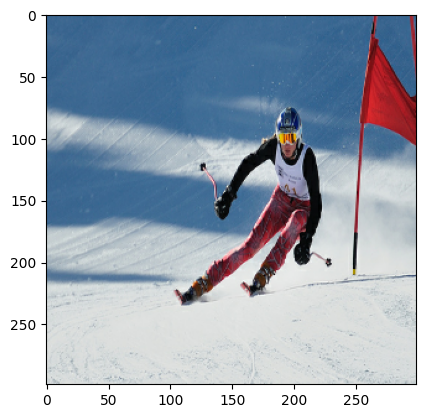

Predicted Caption:  a man in a red is jumping over a snowy hill


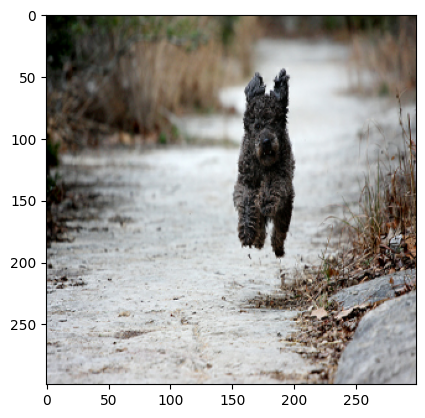

Predicted Caption:  a dog runs through the snow


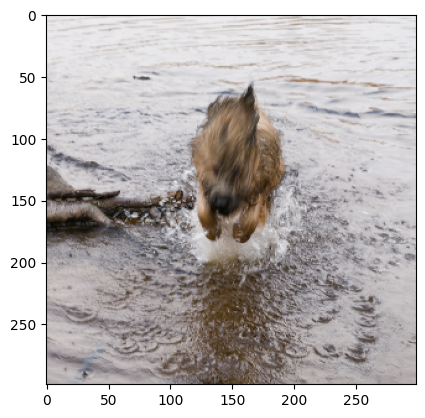

Predicted Caption:  a brown dog is running through the water


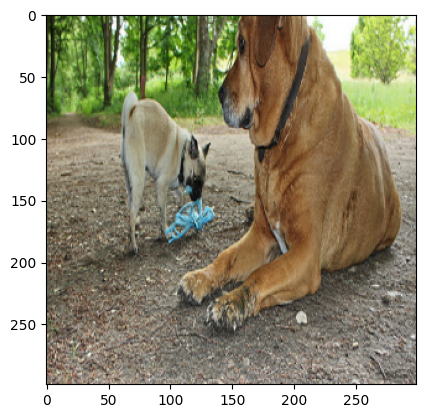

Predicted Caption:  a dog is biting a large brown dog


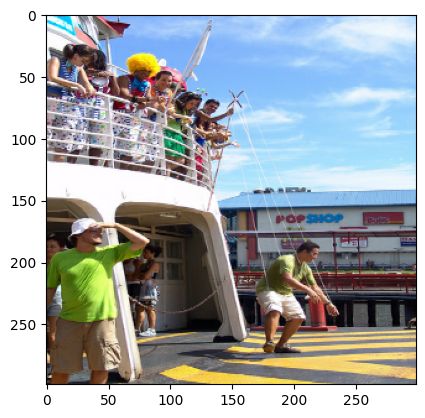

Predicted Caption:  a man is playing a violin on a street


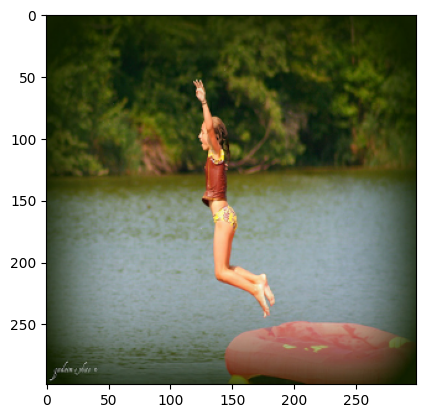

Predicted Caption:  a girl is jumping into the water


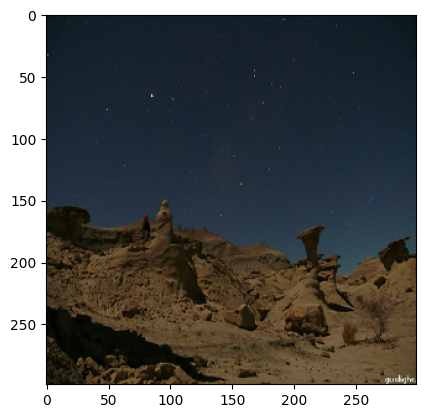

Predicted Caption:  a man is climbing up a rocky hill


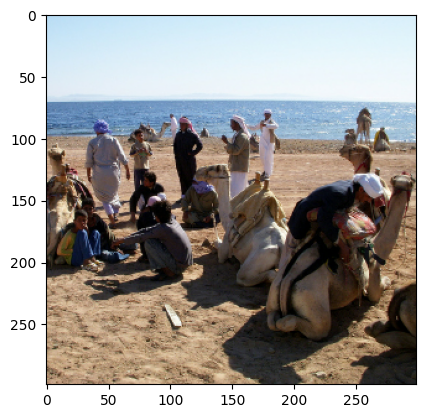

Predicted Caption:  people sit on a dirt track


In [13]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()


Aşağıdaki tüm kodlar yukarıda yazdıklarımızla benzer şekilde çalışmaktadır. Bu kısımda kaggle.com üzerinden bulmuş olduğumuz yeni veri seti ile makineyi eğitip yeni çıktılar elde ettik.


Yeni Data Set:
    Bu veri seti, yolculuk ortası fikri kullanılarak üretilen kapsamlı bir fotoğraf koleksiyonudur. Gelişmiş bir altyazı sistemi aracılığıyla otomatik olarak oluşturulan ilgili istemlerle birlikte çok çeşitli fotoğraflar sağlar.

    Öncelikle difüzyon modeli eğitimi için tasarlanan bu veri seti, görüntü oluşturmada makine öğrenimi yeteneklerini geliştirmek için değerli bir kaynaktır.

In [53]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


keras.utils.set_random_seed(111)

In [54]:
# Path to the images
IMAGES_PATH = "Datasetfordream"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [55]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("updated_modified_combined.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  2463
Number of validation samples:  616


In [56]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [57]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [58]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [59]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='auto',  # Set reduction to 'none' instead of None
)






# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
39/39 [==============================] - 1305s 33s/step - loss: 19.5420 - acc: 0.0951 - val_loss: 7.9542 - val_acc: 0.4967
Epoch 2/30
39/39 [==============================] - 1165s 30s/step - loss: 6.9625 - acc: 0.5241 - val_loss: 6.2099 - val_acc: 0.5766
Epoch 3/30
39/39 [==============================] - 1184s 30s/step - loss: 5.6771 - acc: 0.5885 - val_loss: 5.6168 - val_acc: 0.5963
Epoch 4/30
39/39 [==============================] - 1163s 30s/step - loss: 4.9120 - acc: 0.6240 - val_loss: 5.3321 - val_acc: 0.6115
Epoch 5/30
39/39 [==============================] - 1177s 30s/step - loss: 4.3107 - acc: 0.6562 - val_loss: 5.1452 - val_acc: 0.6243
Epoch 6/30
39/39 [==============================] - 1182s 30s/step - loss: 3.7585 - acc: 0.6894 - val_loss: 4.9708 - val_acc: 0.6322
Epoch 7/30
39/39 [==============================] - 1200s 31s/step - loss: 3.2392 - acc: 0.7213 - val_loss: 5.0523 - val_acc: 0.6308
Epoch 8/30
39/39 [==============================] - 1225s 31s/step -

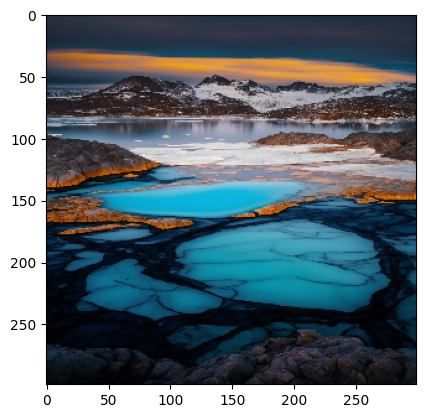

Predicted Caption:  a painting of a mountain with a tree on the background anime style


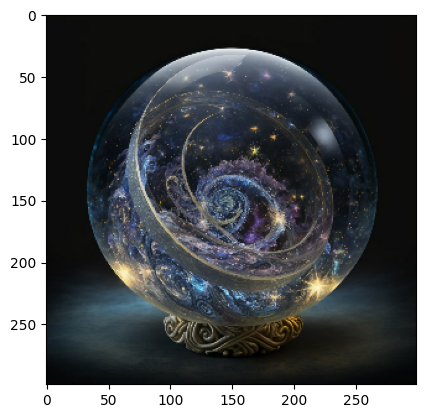

Predicted Caption:  a large cloud with a gold design on it anime style


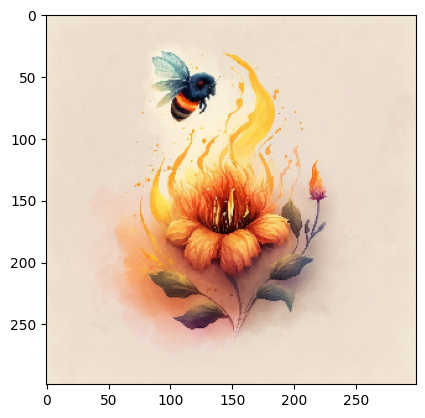

Predicted Caption:  a painting of a colorful bird with a flower anime style


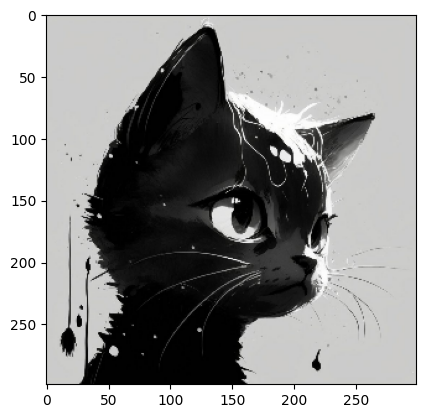

Predicted Caption:  a woman with a very big eyes and a very big breast anime style


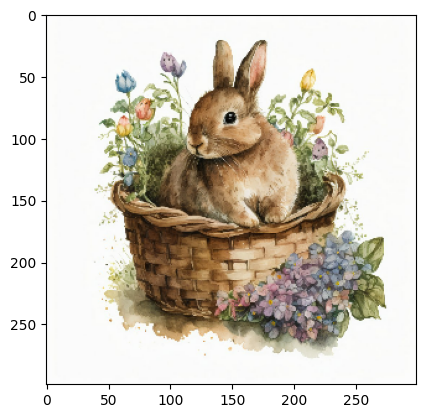

Predicted Caption:  a cat with a lot of it anime style


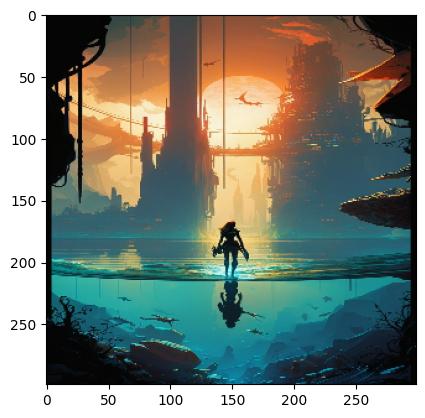

Predicted Caption:  a man standing in front of a building anime style


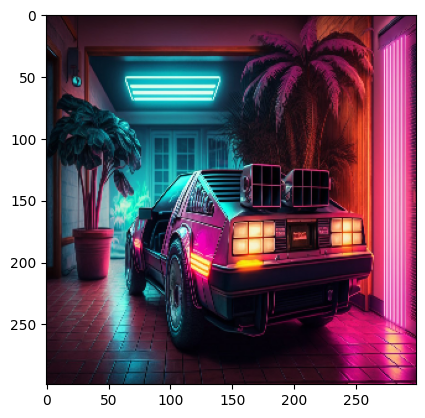

Predicted Caption:  a small island with a car and a car in the middle of it anime style


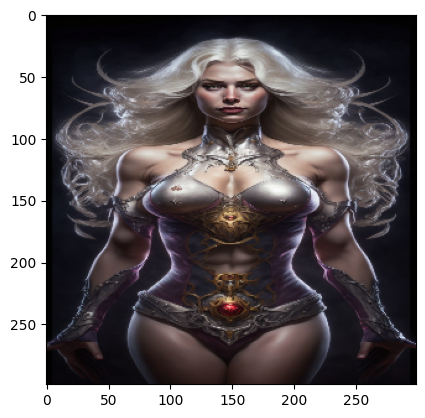

Predicted Caption:  a woman with a black hair and a black and a black background anime style


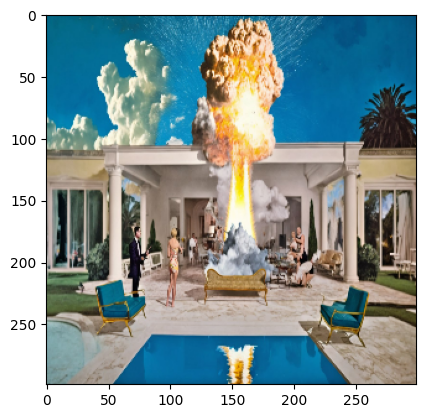

Predicted Caption:  a painting of a man with a flower in the background anime style


In [64]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()


KAYNAKÇA:
    Kod Kaynağı: https://keras.io/examples/vision/image_captioning/
    Örnek Data set: https://www.kaggle.com/datasets/adityajn105/flickr8k
    Farklı Data set: https://www.kaggle.com/datasets/cyanex1702/midjourney-imagesprompt